In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np

%matplotlib inline
#%matplotlib tk
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [4]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls
#from src.Atomic import Collision, SEsolver

from src.Util import Class

from src.Visual import Grotrian

import src.Constants as Cst
#from src.Atomic import LTELib

#from src.Function.StatisticalEquilibrium import LibClass as SELib

from src.Atomic import Hydrogen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
atom, paths = AtomCls.InitAtom("../../data/conf/H.conf", isHydrogen=True)

---

---

## Einstein `Aji` coeficient

In [6]:
ni_arr = atom.Line.idxI[:] + 1
nj_arr = atom.Line.idxJ[:] + 1
Aji = Hydrogen.Einstein_A_coefficient(ni_arr, nj_arr)

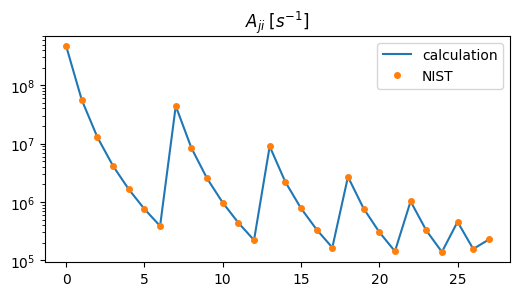

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)
ax.plot( Aji[:], label="calculation")
ax.plot( atom.Line.AJI[:], 'o', markersize=4, label="NIST" )

ax.legend(loc="best")
ax.set_yscale("log")
ax.set_title("$A_{ji} \; [s^{-1}]$")
plt.show()

## Collisional Excitation rate coefficient

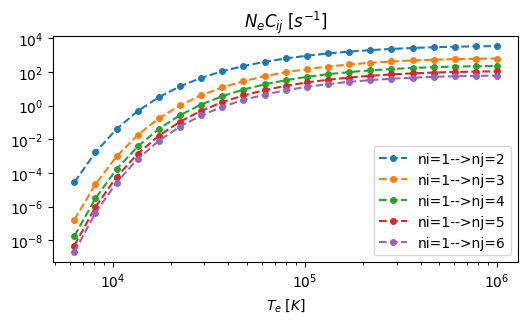

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6
ni = 1
for nj in range(ni+1, k+1):
    Cij = Hydrogen.CE_rate_coe(ni,nj,Te)
    ax.plot( Te, Ne*Cij, '--o', markersize=4, label=f"ni={ni}-->nj={nj}" )

ax.legend(loc="best")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")

ax.set_title("$N_{e}C_{ij} \; [s^{-1}]$")
plt.show()

## Collisional ionization rate coefficient

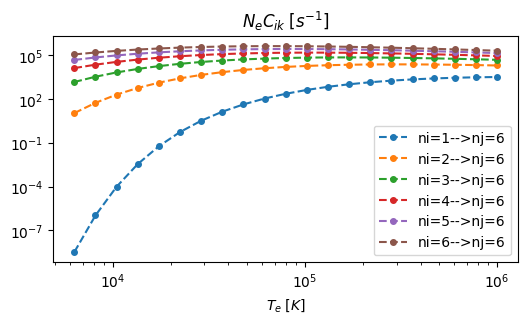

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6
for ni in range(1, k+1):
    Cik = Hydrogen.CI_rate_coe(ni,Te)
    ax.plot( Te, Ne*Cik, '--o', markersize=4, label=f"ni={ni}-->nj={nj}" )

ax.legend(loc="best")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")

ax.set_title("$N_{e}C_{ik} \; [s^{-1}]$")
plt.show()

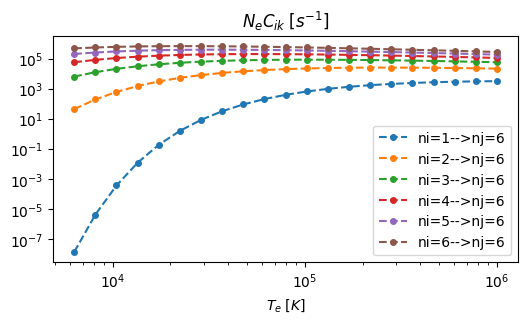

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

n = 21
Te = np.logspace(3.8, 6, n)
Ne = 1E11

k = 6
for ni in range(1, k+1):
    Cik = Hydrogen.CI_rate_coe_clark(ni,Te)
    ax.plot( Te, Ne*Cik, '--o', markersize=4, label=f"ni={ni}-->nj={nj}" )

ax.legend(loc="best")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$T_{e} \; [K]$")

ax.set_title("$N_{e}C_{ik} \; [s^{-1}]$")
plt.show()